There is an extra column called index

keep in mind we are doing liftup analysis

ONLY SINGLE ENTRY PER USER???

variance analysis, anova, pearson correlation

decision trees for feature importance

can straight up train a model with all the features and working through the batches then we can do ablation studies or feature importance analysis 

remove the least importatnt features and retrain the model to get the final results

use liftup analysis as metric to determine the performance of our model

users.total_spend is the label and item that we need to find a correlation for 

##### Features ---- 27
users   - 6
actions - 9
devices - 12

### size of users same as devices -- maybe they changed devices??

#### Could I possibly use reservoir sampling of size 1000 to determine correlation among features as well as label

In [1]:
import os
import subprocess
import pyspark
import pyspark.pandas as ps

from pyspark.sql.types import StructField, StructType, IntegerType, DoubleType, StringType
from pyspark.ml.feature import Binarizer, StringIndexer, UnivariateFeatureSelector
from pyspark.sql.functions import col,isnan, when, count

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.feature import VectorAssembler,VectorIndexer

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

from sklearn.metrics import roc_curve, auc


In [2]:
SQL_LITE_DRVER = "sqlite-jdbc-3.34.0.jar"

if not os.path.exists("./sqlite-jdbc-3.34.0.jar"):
    #### TRY CATCH EXCEPTIONS HERE
    subprocess.run(["curl", 
                    "-O", 
                    f"https://repo1.maven.org/maven2/org/xerial/sqlite-jdbc/3.34.0/{SQL_LITE_DRVER}"
                   ]
                  )


In [3]:
# load devices table column names
col_names = []
txt_data = {}
start = False

print('DATA IN TEXT FILE\n')
_ = subprocess.run(['cat','./kabam_ds_interview/data_dictionary.txt'])

with open('./kabam_ds_interview/data_dictionary.txt') as f:
    for line in f:
        if line.startswith('ka_devices'):
            start = True
        elif start and len(col_names) and len(line)==1:
            break
        elif start and len(line)!=1:
            col_names.append(line.split('-')[0])

print('Device table columns\n')
_ = [print(' - '+col) for col in col_names]


DATA IN TEXT FILE

ka_actions

uid_s - unique user identifier
logins - number of logins since install
game_stats_tutorial_complete - whether user completed tutorial
game_stats_tutorial_complete_time - time (microseconds) to complete game tutorial
game_stats_xp - experience points accumulated by first time interval from install
game_stats_xp1 - experience points accumulated by second time interval from install
game_stats_xp2 - experience points accumulated by third time interval from install
game_stats_xp3 - experience points accumulated by fourth time interval from install
redeemer_actions - number of 'redeemer' actions since install (Note: 'redeemer' is a type of in-game action)
scribe_actions - number of 'scribe' actions since install (Note: 'scribe' is a type of in-game action)


ka_devices (stored in a table called 'devices')

uid_s - unique user identifier
platform_s - installation platform
device_mapped_s - common name for device used
device_manufacturer_s - device manufacturer
d

# Load devices table to pyspark dataframe

In [4]:
if 'devices' not in locals().keys():
    (pyspark.sql.SparkSession.builder
    .master("local[8]")
    .appName("SQLite JDBC")
    .config(
        "spark.jars",
        "./sqlite-jdbc-3.34.0.jar")
    .config(
        "spark.driver.extraClassPath",
        "./sqlite-jdbc-3.34.0.jar")
    .getOrCreate())
    
    devices = ps.read_sql("DEVICES", con="jdbc:sqlite:./kabam_ds_interview/ka_devices.db").to_spark()

print(devices)
devices.show(5, vertical=True)


22/01/08 15:15:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


DataFrame[index: int, uid_s: int, platform_s: string, device_mapped_s: string, device_manufacturer_s: string, device_mem_i: double, device_gmem_i: double, device_mem_grouping_i: double, device_gmem_grouping_i: double, device_numcpu_i: double, device_height_i: double, device_gpu_s: string, device_os_s: string, device_model_s: string]


-RECORD 0--------------------------------------
 index                  | 0                    
 uid_s                  | 0                    
 platform_s             | android              
 device_mapped_s        | asus_x01ad           
 device_manufacturer_s  | asus                 
 device_mem_i           | 3575.0               
 device_gmem_i          | 1024.0               
 device_mem_grouping_i  | 3584.0               
 device_gmem_grouping_i | 1024.0               
 device_numcpu_i        | 8.0                  
 device_height_i        | 720.0                
 device_gpu_s           | adreno (tm) 506      
 device_os_s            | android os 9 / ap... 
 device_model_s         | asus_x01ad           
-RECORD 1--------------------------------------
 index                  | 1                    
 uid_s                  | 1                    
 platform_s             | android              
 device_mapped_s        | moto g (5)           
 device_manufacturer_s  | motorola      

In [37]:
distinct_device_vals = dict()
for col in devices.columns:
    distinct_device_vals[col] = devices.groupby(col).count().count()

_ = [print(f"{val}: {cnt}") for val,cnt in distinct_device_vals.items()]

uid_s: 2845931
platform_s: 2
device_mapped_s: 18978
device_manufacturer_s: 3030
device_mem_i: 2444
device_mem_grouping_i: 113
device_gmem_grouping_i: 9
device_numcpu_i: 13
device_height_i: 216
device_gpu_s: 567
device_os_s: 75074
device_model_s: 19085


In [6]:
devices.groupby('device_gmem_grouping_i').count().show(9)
devices.groupby('device_gmem_i').count().show(9)

+----------------------+-------+
|device_gmem_grouping_i|  count|
+----------------------+-------+
|                 128.0|  22975|
|                1024.0|1237281|
|                  null|      1|
|                4096.0|   1018|
|               16384.0|      1|
|              262144.0|      2|
|                 256.0| 417006|
|                2048.0| 227094|
|                 512.0| 940553|
+----------------------+-------+



+-------------+-------+
|device_gmem_i|  count|
+-------------+-------+
|        128.0|  22975|
|       1024.0|1237281|
|         null|      1|
|       4096.0|   1018|
|      16384.0|      1|
|     262144.0|      2|
|        256.0| 417006|
|       2048.0| 227094|
|        512.0| 940553|
+-------------+-------+



In [7]:
devices = devices.drop('index').drop('device_gmem_i')

# Load the user actions table to spark dataframe

In [8]:
spark = (pyspark.sql.SparkSession.builder
        .master("local[8]")
        .appName("user_action_loader")
        .config("spark.driver.memory", "10g")
        .getOrCreate())

if 'actions' not in locals().keys():
    actions = spark.read.parquet("./kabam_ds_interview/ka_actions.parquet")

    # Check that there is only one instance per user
    assert (actions.select('uid_s').distinct().count() == actions.count())

print(actions)
actions.show(2, vertical=True)

DataFrame[uid_s: bigint, logins: double, game_stats_tutorial_complete: double, game_stats_tutorial_complete_time: double, game_stats_xp: double, game_stats_xp1: double, game_stats_xp2: double, game_stats_xp3: double, redeemer_actions: double, scribe_actions: double]
-RECORD 0-----------------------------------
 uid_s                             | 0      
 logins                            | 7.0    
 game_stats_tutorial_complete      | 1.0    
 game_stats_tutorial_complete_time | 4.7E8  
 game_stats_xp                     | 1693.0 
 game_stats_xp1                    | 592.0  
 game_stats_xp2                    | 0.0    
 game_stats_xp3                    | 429.0  
 redeemer_actions                  | 446.0  
 scribe_actions                    | 364.0  
-RECORD 1-----------------------------------
 uid_s                             | 1      
 logins                            | 2.0    
 game_stats_tutorial_complete      | 1.0    
 game_stats_tutorial_complete_time | 6.12E8 
 game_stats_x

In [38]:
distinct_action_vals = dict()
for col in actions.columns:
    distinct_action_vals[col] = actions.groupby(col).count().count()

_ = [print(f"{val}: {cnt}") for val,cnt in distinct_action_vals.items()]

uid_s: 2845931
logins: 199
game_stats_tutorial_complete: 3
game_stats_tutorial_complete_time: 27948
game_stats_xp: 22260
game_stats_xp1: 5594
game_stats_xp2: 7897
game_stats_xp3: 7836
redeemer_actions: 3747
scribe_actions: 1074


# Load users actions table to spark dataframe

In [10]:
if 'users' not in locals().keys():
    schema = StructType([
        StructField("uid_s", IntegerType()),
        StructField("lang_s", StringType()),
        StructField("geo_s", StringType()),
        StructField("region_s", StringType()),
        StructField("tz_i", IntegerType()),
        StructField("local_time_join_hour", IntegerType()),
        StructField("local_time_join_dow", IntegerType()),
        StructField("total_spend", DoubleType()),

    ])
    users = spark.read.csv("./kabam_ds_interview/ka_users.csv", header=True, schema=schema)

    assert (users.select('uid_s').distinct().count() == users.count())

print(users)
users.show(10)

DataFrame[uid_s: int, lang_s: string, geo_s: string, region_s: string, tz_i: int, local_time_join_hour: int, local_time_join_dow: int, total_spend: double]
+-----+------+-----+--------+------+--------------------+-------------------+-----------+
|uid_s|lang_s|geo_s|region_s|  tz_i|local_time_join_hour|local_time_join_dow|total_spend|
+-----+------+-----+--------+------+--------------------+-------------------+-----------+
|    0|    EN|   MY|    asia| 28800|                  14|                  3|        0.0|
|    1|    ES|   MX|americas|-18000|                  14|                  1|        0.0|
|    2| ZH-CN|   CN|    asia| 28800|                   2|                  3|        0.0|
|    3| ZH-CN|   CN|    asia| 28800|                   8|                  6|        0.0|
|    4|    EN|   IN|    asia| 19800|                  19|                  6|        0.0|
|    5|    EN|   ID|    asia| 25200|                  11|                  6|        0.0|
|    6|    EN|   IN|    asia| 1980

In [39]:
distinct_user_vals = dict()
for col in users.columns:
    distinct_user_vals[col] = users.groupby(col).count().count()

_ = [print(f"{val}: {cnt}") for val,cnt in distinct_user_vals.items()]

uid_s: 2845931
lang_s: 17
geo_s: 229
region_s: 6
tz_i: 34
local_time_join_hour: 24
local_time_join_dow: 7
total_spend: 79


In [12]:
users.select('total_spend').describe().show()

+-------+------------------+
|summary|       total_spend|
+-------+------------------+
|  count|           2845931|
|   mean|1.2153562401899414|
| stddev|13.860695095658928|
|    min|               0.0|
|    max|             450.0|
+-------+------------------+



In [13]:
user_device = users.join(devices, on=['uid_s'], how='left')
user_device_action = user_device.join(actions, on=['uid_s'], how='left')

print(f"Final row count: {user_device_action.count()}\n")
print(f"Final col count: {len(user_device_action.columns)}\n")

print(user_device_action)

Final row count: 2845931

Final col count: 28

DataFrame[uid_s: int, lang_s: string, geo_s: string, region_s: string, tz_i: int, local_time_join_hour: int, local_time_join_dow: int, total_spend: double, platform_s: string, device_mapped_s: string, device_manufacturer_s: string, device_mem_i: double, device_mem_grouping_i: double, device_gmem_grouping_i: double, device_numcpu_i: double, device_height_i: double, device_gpu_s: string, device_os_s: string, device_model_s: string, logins: double, game_stats_tutorial_complete: double, game_stats_tutorial_complete_time: double, game_stats_xp: double, game_stats_xp1: double, game_stats_xp2: double, game_stats_xp3: double, redeemer_actions: double, scribe_actions: double]


### Binarize the total spend and create label (0,1) for (no money spent, money spent)

In [14]:
binarizer = Binarizer(threshold=0.0, inputCol="total_spend", outputCol="label")
binarizedDF = binarizer.transform(user_device)
binarizedDF = binarizedDF.drop("total_spend")

binarizedDF

DataFrame[uid_s: int, lang_s: string, geo_s: string, region_s: string, tz_i: int, local_time_join_hour: int, local_time_join_dow: int, platform_s: string, device_mapped_s: string, device_manufacturer_s: string, device_mem_i: double, device_mem_grouping_i: double, device_gmem_grouping_i: double, device_numcpu_i: double, device_height_i: double, device_gpu_s: string, device_os_s: string, device_model_s: string, label: double]

In [31]:
# df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns]
#    ).show()

# check number of nan values in each label group
# binarizedDF.groupby('label').agg(
#     *[
#         count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in binarizedDF.columns
#     ]
# ).show()


binarizedDF.where(binarizedDF.label==0).select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in binarizedDF.columns]).show(vertical=True)

# instead of doing this twice I should see if there is a Null in any column after grouping by the label then I 
# would know how much of each I would lose by dropping the null rows

-RECORD 0---------------------
 uid_s                  | 0   
 lang_s                 | 0   
 geo_s                  | 125 
 region_s               | 0   
 tz_i                   | 0   
 local_time_join_hour   | 0   
 local_time_join_dow    | 0   
 platform_s             | 0   
 device_mapped_s        | 5   
 device_manufacturer_s  | 5   
 device_mem_i           | 0   
 device_mem_grouping_i  | 0   
 device_gmem_grouping_i | 0   
 device_numcpu_i        | 0   
 device_height_i        | 0   
 device_gpu_s           | 0   
 device_os_s            | 0   
 device_model_s         | 5   
 label                  | 0   



In [32]:
binarizedDF.where(binarizedDF.label==1).select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in binarizedDF.columns]).show(vertical=True)

-RECORD 0---------------------
 uid_s                  | 0   
 lang_s                 | 0   
 geo_s                  | 1   
 region_s               | 0   
 tz_i                   | 0   
 local_time_join_hour   | 0   
 local_time_join_dow    | 0   
 platform_s             | 0   
 device_mapped_s        | 1   
 device_manufacturer_s  | 1   
 device_mem_i           | 1   
 device_mem_grouping_i  | 1   
 device_gmem_grouping_i | 1   
 device_numcpu_i        | 1   
 device_height_i        | 1   
 device_gpu_s           | 1   
 device_os_s            | 1   
 device_model_s         | 1   
 label                  | 0   



In [57]:
# if the counts are small drop every row that has a null value
# binarizedDF = binarizedDF.dropna("any")


all_distinct_vals = dict()
all_distinct_vals.update(distinct_user_vals)
all_distinct_vals.update(distinct_action_vals)
all_distinct_vals.update(distinct_device_vals)

cleaned_df = binarizedDF
col_to_drop = []
for i,col in enumerate(cleaned_df.columns):
    if cleaned_df.dtypes[i][1]=='string' and all_distinct_vals[col] > 1000:
        col_to_drop.append(col)

for col in col_to_drop:
    cleaned_df = cleaned_df.drop(col)

cleaned_df.columns

['uid_s',
 'lang_s',
 'geo_s',
 'region_s',
 'tz_i',
 'local_time_join_hour',
 'local_time_join_dow',
 'platform_s',
 'device_mem_i',
 'device_mem_grouping_i',
 'device_gmem_grouping_i',
 'device_numcpu_i',
 'device_height_i',
 'device_gpu_s',
 'label']

In [122]:
categ_cols = [col for i,col in enumerate(cleaned_df.columns) if cleaned_df.dtypes[i][1]=='string']
categ_indexed = [col+"_idx" for col in categ_cols]

print("The following columns will be string indexed")
print(categ_cols)

stringIndexer = StringIndexer(inputCols=categ_cols, outputCols=categ_indexed)
indexer_model = stringIndexer.fit(binarizedDF)
final_df = indexer_model.transform(cleaned_df)

final_df

The following columns will be string indexed
['lang_s', 'geo_s', 'region_s', 'platform_s', 'device_gpu_s']


DataFrame[uid_s: int, lang_s: string, geo_s: string, region_s: string, tz_i: int, local_time_join_hour: int, local_time_join_dow: int, platform_s: string, device_mem_i: double, device_mem_grouping_i: double, device_gmem_grouping_i: double, device_numcpu_i: double, device_height_i: double, device_gpu_s: string, label: double, lang_s_idx: double, geo_s_idx: double, region_s_idx: double, platform_s_idx: double, device_gpu_s_idx: double]

In [123]:
other_drops = ['uid_s'] # 'geo_s_idx', 

for drop_col in categ_cols+other_drops:
    final_df = final_df.drop(drop_col)

print(f"Num cols : {len(final_df.columns)}\n")
final_df.printSchema()

Num cols : 14

root
 |-- tz_i: integer (nullable = true)
 |-- local_time_join_hour: integer (nullable = true)
 |-- local_time_join_dow: integer (nullable = true)
 |-- device_mem_i: double (nullable = true)
 |-- device_mem_grouping_i: double (nullable = true)
 |-- device_gmem_grouping_i: double (nullable = true)
 |-- device_numcpu_i: double (nullable = true)
 |-- device_height_i: double (nullable = true)
 |-- label: double (nullable = true)
 |-- lang_s_idx: double (nullable = false)
 |-- geo_s_idx: double (nullable = false)
 |-- region_s_idx: double (nullable = false)
 |-- platform_s_idx: double (nullable = false)
 |-- device_gpu_s_idx: double (nullable = false)



In [124]:
# Do one-hot-encoding of categorical variables
from pyspark.ml.feature import OneHotEncoder

cat_one_hot_in = [col for col in categ_indexed if  col in final_df.columns]
cat_one_hot_out = [col+'_hot' for col in cat_one_hot_in]

ohe = OneHotEncoder()
ohe.setInputCols(cat_one_hot_in)
ohe.setOutputCols(cat_one_hot_out)

OneHotEncoder_ae56a8ec219b

In [125]:
ohe_model = ohe.fit(final_df)

final_df_2 = ohe_model.transform(final_df)
final_df_2.show(1, vertical=True)

-RECORD 0----------------------------------
 tz_i                   | 28800            
 local_time_join_hour   | 7                
 local_time_join_dow    | 6                
 device_mem_i           | 5724.0           
 device_mem_grouping_i  | 5760.0           
 device_gmem_grouping_i | 2048.0           
 device_numcpu_i        | 8.0              
 device_height_i        | 1080.0           
 label                  | 0.0              
 lang_s_idx             | 1.0              
 geo_s_idx              | 0.0              
 region_s_idx           | 0.0              
 platform_s_idx         | 0.0              
 device_gpu_s_idx       | 24.0             
 lang_s_idx_hot         | (16,[1],[1.0])   
 geo_s_idx_hot          | (227,[0],[1.0])  
 region_s_idx_hot       | (5,[0],[1.0])    
 platform_s_idx_hot     | (1,[0],[1.0])    
 device_gpu_s_idx_hot   | (564,[24],[1.0]) 
only showing top 1 row



In [126]:
for col in cat_one_hot_in:
    final_df_2 = final_df_2.drop(col)

final_df_2.printSchema()

root
 |-- tz_i: integer (nullable = true)
 |-- local_time_join_hour: integer (nullable = true)
 |-- local_time_join_dow: integer (nullable = true)
 |-- device_mem_i: double (nullable = true)
 |-- device_mem_grouping_i: double (nullable = true)
 |-- device_gmem_grouping_i: double (nullable = true)
 |-- device_numcpu_i: double (nullable = true)
 |-- device_height_i: double (nullable = true)
 |-- label: double (nullable = true)
 |-- lang_s_idx_hot: vector (nullable = true)
 |-- geo_s_idx_hot: vector (nullable = true)
 |-- region_s_idx_hot: vector (nullable = true)
 |-- platform_s_idx_hot: vector (nullable = true)
 |-- device_gpu_s_idx_hot: vector (nullable = true)



In [127]:
assembler = VectorAssembler(inputCols = final_df_2.drop('label').columns, outputCol = "features")
assembled = assembler.transform(final_df_2)

assembled.printSchema()

root
 |-- tz_i: integer (nullable = true)
 |-- local_time_join_hour: integer (nullable = true)
 |-- local_time_join_dow: integer (nullable = true)
 |-- device_mem_i: double (nullable = true)
 |-- device_mem_grouping_i: double (nullable = true)
 |-- device_gmem_grouping_i: double (nullable = true)
 |-- device_numcpu_i: double (nullable = true)
 |-- device_height_i: double (nullable = true)
 |-- label: double (nullable = true)
 |-- lang_s_idx_hot: vector (nullable = true)
 |-- geo_s_idx_hot: vector (nullable = true)
 |-- region_s_idx_hot: vector (nullable = true)
 |-- platform_s_idx_hot: vector (nullable = true)
 |-- device_gpu_s_idx_hot: vector (nullable = true)
 |-- features: vector (nullable = true)



In [128]:
# selector = UnivariateFeatureSelector(outputCol="selectedFeatures")
# selector.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(5)

# model = selector.fit(assembled)

# model.setFeaturesCol("features")
# model.transform(assembled.drop('label')).head().selectedFeatures

# top_features = [assembled.drop('label').columns[i] for i in model.selectedFeatures]
# print(top_features)

## Fix dataset imbalance

In [129]:
# Need to calculate ratio first here

majority_df = assembled.filter(assembled.label == 0)
minority_df = assembled.filter(assembled.label == 1)

# sampled_majority_df = majority_df.sample(False, 1/87)

sampled_majority_df, extra_maj_df = majority_df.randomSplit([1/87, 86/87], seed=0)

balanced_df = sampled_majority_df.unionAll(minority_df)

balanced_df.groupby('label').count().show()

22/01/08 19:14:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/08 19:14:30 WARN RowBasedKeyValueBatch: Calling spill() on

+-----+-----+
|label|count|
+-----+-----+
|  0.0|32566|
|  1.0|32395|
+-----+-----+



In [130]:
# majority_df = assembled.filter(assembled.label == 0)
# minority_df = assembled.filter(assembled.label == 1)

# sample_positive = majority_df.take(1000)
# sample_negative = minority_df.take(1000)

# sample = spark.createDataFrame(data = sample_positive).union(spark.createDataFrame(data = sample_negative))
# sub_sample = sample.toPandas()

# # plotting the scatter matrix with the features
# plt.figure(figsize=(10,10))
# plt.plot(sub_sample.device_mem_grouping_i, sub_sample.label,'.')
# # scatter_matrix(
# #     sub_sample[['label','device_mem_grouping_i']],
# #     figsize=(10,8))
# plt.show()

# Test train split

In [131]:
(training_data, test_data) = balanced_df.randomSplit([0.7, 0.3], seed=0)

In [132]:
# test training a classifier with the special variables
# IF THIS TRAINS FINE THEN WE CAN DO OPTIMIZATION ON GOOGLE COLAB WITH SOME HINTS ABOUT THE TOP FEATURES

### WOOOOHOOOOOO

tree_class = DecisionTreeClassifier(maxDepth=5, labelCol="label", leafCol="leafId")
trained_model = tree_class.fit(training_data.select('features','label'))

In [133]:
important_features = trained_model.featureImportances
important_features


SparseVector(821, {0: 0.0033, 2: 0.0005, 4: 0.6051, 7: 0.1575, 13: 0.0004, 25: 0.0549, 27: 0.1028, 64: 0.0005, 256: 0.0048, 268: 0.05, 273: 0.0006, 296: 0.0197})

In [134]:
print(important_features)

(821,[0,2,4,7,13,25,27,64,256,268,273,296],[0.0032542306945896196,0.0005339410185588615,0.6050563883129559,0.15751249341754986,0.00038562406895917804,0.05486304107551754,0.10284983729342827,0.0005437799739972093,0.004776281573776148,0.04997034671867137,0.0005610130121440138,0.019693022839851797])


In [135]:
important_list = sorted([(i,prob) for i,prob in enumerate(important_features) if prob != 0],
                        reverse=True, key = lambda x: x[1])
_ = [print(val) for val in important_list]

(4, 0.6050563883129559)
(7, 0.15751249341754986)
(27, 0.10284983729342827)
(25, 0.05486304107551754)
(268, 0.04997034671867137)
(296, 0.019693022839851797)
(256, 0.004776281573776148)
(0, 0.0032542306945896196)
(273, 0.0005610130121440138)
(64, 0.0005437799739972093)
(2, 0.0005339410185588615)
(13, 0.00038562406895917804)


In [136]:
training_data.show(1,vertical=True)

-RECORD 0--------------------------------------
 tz_i                   | -39600               
 local_time_join_hour   | 4                    
 local_time_join_dow    | 7                    
 device_mem_i           | 977.0                
 device_mem_grouping_i  | 1024.0               
 device_gmem_grouping_i | 256.0                
 device_numcpu_i        | 4.0                  
 device_height_i        | 800.0                
 label                  | 0.0                  
 lang_s_idx_hot         | (16,[0],[1.0])       
 geo_s_idx_hot          | (227,[4],[1.0])      
 region_s_idx_hot       | (5,[1],[1.0])        
 platform_s_idx_hot     | (1,[0],[1.0])        
 device_gpu_s_idx_hot   | (564,[3],[1.0])      
 features               | (821,[0,1,2,3,4,5... 
only showing top 1 row



In [137]:
training_data.schema["features"].metadata["ml_attr"]['attrs']['binary'][0]

{'idx': 8, 'name': 'lang_s_idx_hot_EN'}

In [138]:
tree_priority = []

ml_attrs = training_data.schema["features"].metadata["ml_attr"]['attrs']

for i,prob in enumerate(important_features):
    if prob > 0:
        if i<= 8:
            feat_name = ml_attrs['numeric'][i]['name']
        else:
            feat_name = ml_attrs['binary'][i-9]['name']

        tree_priority.append((feat_name, prob))
    
tree_priority.sort(reverse=True, key = lambda x: x[1])

_ = [print(f"{items[0]:<50}:\t {items[1]}") for items in tree_priority]

device_mem_grouping_i                             :	 0.6050563883129559
device_height_i                                   :	 0.15751249341754986
geo_s_idx_hot_BR                                  :	 0.10284983729342827
geo_s_idx_hot_CN                                  :	 0.05486304107551754
device_gpu_s_idx_hot_mali-g71                     :	 0.04997034671867137
device_gpu_s_idx_hot_powervr sgx 554              :	 0.019693022839851797
region_s_idx_hot_oceania                          :	 0.004776281573776148
tz_i                                              :	 0.0032542306945896196
device_gpu_s_idx_hot_apple a12 gpu                :	 0.0005610130121440138
geo_s_idx_hot_CZ                                  :	 0.0005437799739972093
local_time_join_dow                               :	 0.0005339410185588615
lang_s_idx_hot_RU                                 :	 0.00038562406895917804


In [139]:
preds = trained_model.transform(test_data)

In [140]:
results = preds.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

[14933.913s][warning][gc,alloc] Executor task launch worker for task 4.0 in stage 693.0 (TID 1540): Retried waiting for GCLocker too often allocating 262146 words
[14933.920s][warning][gc,alloc] Executor task launch worker for task 6.0 in stage 693.0 (TID 1542): Retried waiting for GCLocker too often allocating 262146 words


22/01/08 19:23:57 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/01/08 19:23:57 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.


In [141]:
print(results_list[:10])

test_data.select('label').show(10)

[(0.9698910954516335, 1.0), (0.8024216524216524, 1.0), (0.36971843332515164, 1.0), (0.43920145190562615, 1.0), (0.8024216524216524, 1.0), (0.8024216524216524, 1.0), (0.594475138121547, 1.0), (0.8024216524216524, 1.0), (0.36971843332515164, 1.0), (0.43920145190562615, 1.0)]


+-----+
|label|
+-----+
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
+-----+
only showing top 10 rows



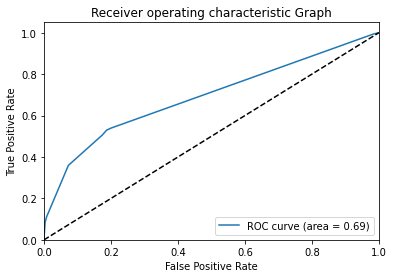

In [142]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()